# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from stargazer.stargazer import Stargazer

from proj03 import cgmwildboot

%load_ext autoreload
%autoreload 2

# Import data

In [2]:
# import data
baseline = pd.read_stata('data/baseline.dta')
cleanpricedata_y1y2 = pd.read_stata('data/cleanPriceData_Y1Y2.dta')
ms1ms2_pooled = pd.read_stata('data/MS1MS2_pooled.dta')

# this data is not needed for our analysis
# bok_inflation = pd.read_stata('data/BOK_inflation.dta')
# intensity_obs_short = pd.read_stata('data/intensity_obs_short.dta')
# lrfu_select_dataset = pd.read_stata('data/LRFU_select_dataset.dta')
# repayment_datay1 = pd.read_stata('data/repayment_dataY1.dta')

# Recreating the tables from the paper

## Table 1

We start by cleaning the data

In [3]:
# clean ms1ms2_pooled (drop if MS !=2, keep columns oafid and treatMS1MS2, group by oafid and take mean and rename)
ms1ms2_pooled_tab1 = ms1ms2_pooled[ms1ms2_pooled['MS']==2]
ms1ms2_pooled_tab1 = ms1ms2_pooled_tab1[['oafid', 'treatMS1MS2']]
ms1ms2_pooled_tab1 = ms1ms2_pooled_tab1.groupby('oafid', as_index=False).mean()
ms1ms2_pooled_tab1.rename(columns={'treatMS1MS2': 'treat13'}, inplace=True)

In [4]:
# clean baseline data (the stata code indicates that the variables columns 'businessprofitmonth' and 'delta' should be kept, however they have already been renamed to 'businessprofitmonth_base' and 'delta_base')
base_cols = ['oafid', 'logtotcons_base', 'male', 'num_adults', 'num_schoolchildren', 'finished_primary',
                   'finished_secondary', 'cropland', 'num_rooms', 'schoolfees', 'totcons_base', 'logpercapcons_base',
                   'total_cash_savings_base', 'total_cash_savings_trimmed', 'has_savings_acct', 'taken_bank_loan',
                   'taken_informal_loan', 'liquidWealth', 'wagepay', 'businessprofitmonth_base', 'price_avg_diff_pct',
                   'price_expect_diff_pct', 'harvest2011', 'netrevenue2011', 'netseller2011', 'autarkic2011',
                   'maizelostpct2011', 'harvest2012', 'correct_interest', 'digit_recall', 'maizegiver', 'delta_base', 'treatment']
baseline_clean = baseline[base_cols].copy()

# rename columns
baseline_clean.columns = [col + '_base' if not col.endswith('_base') and col != 'oafid' and col != 'treatment' else col for col in baseline_clean.columns]
baseline_clean.rename(columns={'treatment': 'treatment2012'}, inplace=True)

# generate treat12 as bool for treatment and control in 2012
baseline_clean['treat12'] = baseline_clean['treatment2012'].apply(lambda x: x in ['T1', 'T2'])
baseline_clean.loc[baseline_clean['treatment2012'] == '', 'treat12'] = np.nan

/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_86495/2284489521.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  baseline_clean.loc[baseline_clean['treatment2012'] == '', 'treat12'] = np.nan


In [5]:
# merge baseline_clean and ms1ms2_pooled_clean on oafid
base_ms1ms2_pool = pd.merge(baseline_clean, ms1ms2_pooled_tab1, on='oafid', how='left')

In [6]:
# create table 1
# copy in case we need this later
df_tab1 = base_ms1ms2_pool.copy()
df_tab1['schoolfees_base'] = df_tab1['schoolfees_base']*1000

# var list for table 1
vars_list = [
    "male_base", "num_adults_base", "num_schoolchildren_base", "finished_primary_base",
    "finished_secondary_base", "cropland_base", "num_rooms_base", "schoolfees_base",
    "totcons_base", "logpercapcons_base", "total_cash_savings_base",
    "total_cash_savings_trimmed_base", "has_savings_acct_base", "taken_bank_loan_base",
    "taken_informal_loan_base", "liquidWealth_base", "wagepay_base",
    "businessprofitmonth_base", "price_avg_diff_pct_base",
    "price_expect_diff_pct_base", "harvest2011_base", "netrevenue2011_base",
    "netseller2011_base", "autarkic2011_base", "maizelostpct2011_base",
    "harvest2012_base", "correct_interest_base", "digit_recall_base",
    "maizegiver_base"
]

renaming = {
    "male_base": "Male",
    "num_adults_base": "Number of adults",
    "num_schoolchildren_base": "Children in school",
    "finished_primary_base": "Finished primary school",
    "finished_secondary_base": "Finished secondary school",
    "cropland_base": "Total cropland (acres)",
    "num_rooms_base": "Number of rooms in household",
    "schoolfees_base": "Total school fees",
    "totcons_base": "Average monthly consumption (Ksh)",
    "logpercapcons_base": "Average monthly consumption/capita (log)",
    "total_cash_savings_base": "Total cash savings (Ksh)",
    "total_cash_savings_trimmed_base": "Total cash savings (trim)",
    "has_savings_acct_base": "Has bank savings acct",
    "taken_bank_loan_base": "Taken bank loan",
    "taken_informal_loan_base": "Taken informal loan",
    "liquidWealth_base": "Liquid wealth (Ksh)",
    "wagepay_base": "Off-farm wages (Ksh)",
    "businessprofitmonth_base": "Business profit (Ksh)",
    "price_avg_diff_pct_base": "Avg $\%\Delta$ price Sep-Jun",
    "price_expect_diff_pct_base": "Expect $\%\Delta$ price Sep12-Jun13",
    "harvest2011_base": "2011 LR harvest (bags)",
    "netrevenue2011_base": "Net revenue 2011 (Ksh)",
    "netseller2011_base": "Net seller 2011",
    "autarkic2011_base": "Autarkic 2011",
    "maizelostpct2011_base": "\% maize lost 2011",
    "harvest2012_base": "2012 LR harvest (bags)",
    "correct_interest_base": "Calculated interest correctly",
    "digit_recall_base": "Digit span recall",
    "maizegiver_base": "Maize giver"
}

# function to perform t-tests
def t_test_by_group(df, var, group_var='treat12'):
    group1 = df[df[group_var] == 0][var].dropna()
    group2 = df[df[group_var] == 1][var].dropna()
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=True)
    return group1.mean(), group2.mean(), len(group1) + len(group2), t_stat, p_val

# applying t-tests and collecting results
results = []
for var in vars_list:
    control_mean, treat_mean, obs, t_stat, p_val = t_test_by_group(df_tab1, var)
    std_diff = (treat_mean - control_mean) / np.std(df_tab1[df_tab1['treat12'] == 0][var])
    results.append([var, treat_mean, control_mean, obs, std_diff, p_val])

# convert results to a df to use pandas output to latex
results_df = pd.DataFrame(results, columns=['Variable', 'Treat Mean', 'Control Mean', 'Observations', 'Std Diff', 'P-value'])
results_df['Variable'] = results_df['Variable'].map(renaming)
results_df = results_df.rename(columns={
    'Variable':'Baseline characteristic', 
    'Treat Mean':'Treat', 
    'Control Mean':'Control', 
    'Observations':'Obs', 
    'Std Diff':'Std diff', 
    'P-value':'P-val'})

latex_table1 = results_df.to_latex(index=False, float_format="%.3f")
latex_table1 = latex_table1.replace('\\toprule', '\\\[-1.8ex]\hline \n \hline \\\[-1.8ex]')
latex_table1 = latex_table1.replace('\\bottomrule', '\\\[-1.8ex]\hline \n \hline \\\[-1.8ex]')

with open('tables/table1.tex','w') as file:
    file.write(latex_table1)

## Running the model for tables 2 through 4

In [7]:
treatments = ['treat12', 'treat13', 'treatMS1MS2']
dependent_vars = ['inventory_trim', 'netrevenue_trim','logtotcons_trim']

mean_df = pd.DataFrame()
std_df = pd.DataFrame()
pval_df = pd.DataFrame()
pval_rd_df = pd.DataFrame()

results = {'netsales': {'overall': None, 'by_round':None}}

for dv in dependent_vars:
    for treat in treatments:
        # create df for each treatment
        if treat == 'treatMS1MS2':
            df1 = ms1ms2_pooled.loc[:, [dv,'treat12', 'Y1round1', 'Y1round2', 'Y1round3', 'treatMS1MS2', 'interviewdate', 'groupnum', 'strata_group']].copy(deep=True).dropna()
            df2 = ms1ms2_pooled.loc[:, [dv,'treat13', 'Y2round1', 'Y2round2', 'Y2round3', 'treatMS1MS2', 'interviewdate', 'groupnum', 'strata_group']].copy(deep=True).dropna()
            df1['inter_R1'] = df1['Y1round1'] * df1[f'treat12']
            df1['inter_R2'] = df1['Y1round2'] * df1[f'treat12']
            df1['inter_R3'] = df1['Y1round3'] * df1[f'treat12']
            df2['inter_R1'] = df2['Y2round1'] * df2[f'treat13']
            df2['inter_R2'] = df2['Y2round2'] * df2[f'treat13']
            df2['inter_R3'] = df2['Y2round3'] * df2[f'treat13']
            df = pd.concat([df1, df2], ignore_index=True).fillna(0)

            # model specification by round
            formula_by_round = f'{dv} ~ inter_R1 + inter_R2 + inter_R3 + interviewdate + C(Y1round1) + C(Y1round2) + C(Y1round3) + C(Y2round1) + C(Y2round2) + C(Y2round3) + C(strata_group)'
        else:
            if treat == 'treat12':
                year = 1
            else:
                year = 2
            df = ms1ms2_pooled.loc[:, [dv,treat, f'Y{year}round1', f'Y{year}round2', f'Y{year}round3', 'treatMS1MS2', 'interviewdate', 'groupnum', 'strata_group']].copy(deep=True).dropna()
            df['inter_R1'] = df[f'Y{year}round1'] * df[f'{treat}']
            df['inter_R2'] = df[f'Y{year}round2'] * df[f'{treat}']
            df['inter_R3'] = df[f'Y{year}round3'] * df[f'{treat}']


            # model specification by round
            formula_by_round = f'{dv} ~ inter_R1 + inter_R2 + inter_R3 + interviewdate + C(Y{year}round1) + C(Y{year}round2) + C(Y{year}round3) + C(strata_group)'
        
        df['z'] = df[treat]

        # specify overall model
        formula_overall = f'{dv} ~ z + interviewdate + C(strata_group)'

        # fit models
        model_overall = smf.ols(formula_overall, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['groupnum']})
        model_by_round = smf.ols(formula_by_round, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['groupnum']})

        # store models in dictionary
        results[f'{treat}_{dv}'] = {f'overall': model_overall, f'by_round': model_by_round}
        # extract necessary statistics
        mean_df.loc[dv, treat] = df[dv].mean()
        std_df.loc[dv, treat] = df[dv].std()
        pval_df.loc[dv, treat] = 2 * (1 - stats.t.cdf(np.abs(model_overall.params['z']/model_overall.bse['z']),df=df['groupnum'].nunique()-1))

        for var in ['inter_R1', 'inter_R2', 'inter_R3']:
            pval_rd_df.loc[f'{dv}_{var}', f'{treat}_rd'] = 2 * (1 - stats.t.cdf(np.abs(model_by_round.params[var]/model_by_round.bse[var]),df=df['groupnum'].nunique()-1))

## Adding table 5

### Clean the data

In [8]:
ms1ms2_pooled_tab5 = ms1ms2_pooled.copy(deep=True)
max_strata_group = ms1ms2_pooled_tab5['strata_group'].max()
ms1ms2_pooled_tab5.loc[ms1ms2_pooled_tab5['MS'] == 2, 'strata_group'] = ms1ms2_pooled_tab5['groupstrata'] + max_strata_group

ms1ms2_pooled_tab5.loc[ms1ms2_pooled_tab5['MS'] == 2, 'oafid'] = ms1ms2_pooled_tab5['fr_id']

ms1ms2_pooled_tab5['purchasequant2'] = ms1ms2_pooled_tab5['purchasequant']
ms1ms2_pooled_tab5.loc[(ms1ms2_pooled_tab5['purchaseval']==0)&(ms1ms2_pooled_tab5['purchasequant'].isna()),'purchasequant2'] = 0
ms1ms2_pooled_tab5['netsales'] = ms1ms2_pooled_tab5['salesquant'] - ms1ms2_pooled_tab5['purchasequant2']

ms1ms2_pooled_tab5.drop(columns=['netsales_trim','purchaseval_trim','salesval_trim'], inplace=True)

In [9]:
# trim outliers
for x in ['purchaseval', 'salesval', 'purchasequant', 'salesquant']:
    quantile = np.quantile(ms1ms2_pooled_tab5[ms1ms2_pooled_tab5[x].notna()][x],[0.99],method='closest_observation')
    ms1ms2_pooled_tab5[f'{x}_trim'] = ms1ms2_pooled_tab5[x]
    ms1ms2_pooled_tab5.loc[ms1ms2_pooled_tab5[f'{x}_trim'] > quantile[0],f'{x}_trim'] = np.nan

quantile = np.quantile(ms1ms2_pooled_tab5[ms1ms2_pooled_tab5['netsales'].notna()]['netsales'],[0.005, 0.995],method='closest_observation')
ms1ms2_pooled_tab5['netsales_trim'] = ms1ms2_pooled_tab5['netsales']
ms1ms2_pooled_tab5.loc[(ms1ms2_pooled_tab5['netsales_trim'] <= quantile[0]) | (ms1ms2_pooled_tab5['netsales_trim'] > quantile[1]) , 'netsales_trim'] = np.nan

# create id
ms1ms2_pooled_tab5['id'] = ms1ms2_pooled_tab5['oafid'].fillna(ms1ms2_pooled_tab5['fr_id'])

# create effective prices
trim_vars = ['salesquant_trim', 'purchasequant_trim', 'salesval_trim', 'purchaseval_trim']
for var in trim_vars:
    ms1ms2_pooled_tab5[f'tot_{var}'] = ms1ms2_pooled_tab5.groupby(['id', 'MS'])[var].transform('sum')

for x in ['purchase', 'sales']:
    ms1ms2_pooled_tab5[f'effective_{x}_price'] = ms1ms2_pooled_tab5[f'tot_{x}val_trim'] / ms1ms2_pooled_tab5[f'tot_{x}quant_trim']
    ms1ms2_pooled_tab5.loc[ms1ms2_pooled_tab5[f'tot_{x}quant_trim']== 0,f'effective_{x}_price'] = np.nan

### Net sales

In [10]:
# define variable
dv = 'netsales_trim'
independent_vars = ['z', 'treatMS1MS2_1 + treatMS1MS2_2 + treatMS1MS2_3']

for i, var in enumerate(independent_vars):
    df = ms1ms2_pooled_tab5.copy(deep=True)
    df['z'] = df['treatMS1MS2']
    if var == 'z':
        df.dropna(subset=[dv,'z','interviewdate','Y1round2','Y1round3','Y2round1','Y2round2','Y2round3','strata_group','groupnum'], inplace=True)
    else:
        df.dropna(subset=[dv,'treatMS1MS2_1','treatMS1MS2_2','treatMS1MS2_3','interviewdate','Y1round2','Y1round3','Y2round1','Y2round2','Y2round3','strata_group','groupnum'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    formula = f'{dv} ~ {var} + interviewdate + Y1round2 + Y1round3 + Y2round1 + Y2round2 + Y2round3 + C(strata_group)'
    model = smf.ols(formula, df).fit(cov_type='cluster', cov_kwds={'groups': df['groupnum']})
    if i == 0:
        results['netsales']['overall'] = model
    else:
        results['netsales']['by_round'] = model
    
    mean_df.loc[dv, treat] = df.loc[df['treatMS1MS2'] == 0, dv].mean()
    std_df.loc[dv, treat] = df.loc[df['treatMS1MS2'] == 0, dv].std()


/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_86495/2854517969.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.4208270957978571' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  mean_df.loc[dv, treat] = df.loc[df['treatMS1MS2'] == 0, dv].mean()


### Effective Price

In [11]:
for dv in ['purchase', 'sales']:
    for i, treat in enumerate(['treat12', 'treat13', 'treatMS1MS2']):
        df = ms1ms2_pooled_tab5.copy(deep=True)
        df['z'] = df[treat]
        df = df.drop_duplicates(subset=['id', 'MS'], keep='first')
        df.dropna(subset=[f'effective_{dv}_price','z','groupnum'], inplace=True)
        if treat == 'treatMS1MS2':
            formula = f'effective_{dv}_price ~ z + C(strata_group)'
        else:
            df = df[df['MS'] == i+1]
            formula = f'effective_{dv}_price ~ z + C(strata_group)'
        model = smf.ols(formula, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['groupnum']})
        results[f'{treat}_{dv}'] = {'overall':model}
        
        mean_df.loc[dv, treat] = df.loc[df['z'] == 0, f'effective_{dv}_price'].mean()
        std_df.loc[dv, treat] = df.loc[df['z'] == 0, f'effective_{dv}_price'].std()
        pval_df.loc[dv, treat] = 2 * (1 - stats.t.cdf(np.abs(model.params['z']/model.bse['z']),df=df['groupnum'].nunique()-1))

/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_86495/1060375524.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2774.7609839746265' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  mean_df.loc[dv, treat] = df.loc[df['z'] == 0, f'effective_{dv}_price'].mean()
/var/folders/yw/jsw5n53s1cb1s2q6tt0msrm00000gn/T/ipykernel_86495/1060375524.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2858.969741383102' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  mean_df.loc[dv, treat] = df.loc[df['z'] == 0, f'effective_{dv}_price'].mean()


## Calculating FWER and pvals and getting dataframes ready for output

In [12]:
for treat in ['treat12', 'treat13', 'treatMS1MS2']:        
    fwer_pvals = multipletests(pval_df[treat], alpha=0.05, method='fdr_bh')[1]
    for i, dv in enumerate(pval_df.index):
        pval_df.loc[dv, f'{treat}_fwer'] = fwer_pvals[i]
    fwer_pvals_rd = multipletests(pval_rd_df[f'{treat}_rd'], alpha=0.05, method='fdr_bh')[1]
    for i, indx in enumerate(pval_rd_df.index):
        pval_rd_df.loc[indx, f'{treat}_fwer_rd'] = fwer_pvals_rd[i]

In [13]:
# combine the p-values and split into two dfs
pvals = pd.concat([pval_df, pval_rd_df], axis=0)
pvals = pvals.map(lambda x: '<0.001' if x < 0.0005 else np.round(x,3))
pval_fwer = pvals[['treat12_fwer','treat12_fwer_rd','treat13_fwer','treat13_fwer_rd','treatMS1MS2_fwer','treatMS1MS2_fwer_rd']]
pval = pvals[['treat12','treat12_rd','treat13','treat13_rd','treatMS1MS2','treatMS1MS2_rd']]

In [14]:
# adjust the mean and std dfs to be ready for output
for treat in mean_df.columns:
    mean_df[f'{treat}_rd'] = mean_df[treat]
    std_df[f'{treat}_rd'] = std_df[treat]

# sort the dfs
mean_df = mean_df[['treat12','treat12_rd','treat13','treat13_rd','treatMS1MS2','treatMS1MS2_rd']].map(lambda x: np.round(x,3))
std_df = std_df[['treat12','treat12_rd','treat13','treat13_rd','treatMS1MS2','treatMS1MS2_rd']].map(lambda x: np.round(x,3))


## Output table to LaTeX

### Tables 2,3 and 4 to LaTeX

In [15]:
latex_tables = []
for i, dv in enumerate(['inventory_trim', 'netrevenue_trim', 'logtotcons_trim']):
    tables = []
    for treat in ['treat12', 'treat13', 'treatMS1MS2']:
        overall = results[f'{treat}_{dv}']['overall']
        by_rd = results[f'{treat}_{dv}']['by_round']
        tables.append(overall)
        tables.append(by_rd)
    stargazer = Stargazer(tables)
    stargazer.custom_columns(['Y1', 'Y2','Pooled'], [2,2,2])
    stargazer.significant_digits(3)
    stargazer.rename_covariates({'z': 'Treat', 'inter_R1': 'Treat - R1', 'inter_R2': 'Treat - R2', 'inter_R3': 'Treat - R3'})
    stargazer.covariate_order(['z', 'inter_R1', 'inter_R2', 'inter_R3'])
    stargazer.show_adj_r2 = False
    stargazer.show_f_statistic = False
    stargazer.show_residual_std_err = False
    stargazer.show_notes = False
    
    # adding custom rows with mean, sd, and p-values
    stargazer.add_line('Mean DV', mean_df.loc[dv].tolist(),location='fb')
    stargazer.add_line('SD DV', std_df.loc[dv].tolist(),location='fb')
    stargazer.add_line('P-Val Treat', pval.loc[dv].tolist(),location='fb')
    stargazer.add_line('P-Val Treat FWER', pval_fwer.loc[dv].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R1', pval.loc[f'{dv}_inter_R1'].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R1 FWER', pval_fwer.loc[f'{dv}_inter_R1'].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R2', pval.loc[f'{dv}_inter_R2'].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R2 FWER', pval_fwer.loc[f'{dv}_inter_R2'].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R3', pval.loc[f'{dv}_inter_R3'].tolist(),location='fb')
    stargazer.add_line('P-Val Treat - R3 FWER', pval_fwer.loc[f'{dv}_inter_R3'].tolist(),location='fb')
    
    latex_table = stargazer.render_latex()

    # general formatting
    latex_table = latex_table.replace("\\textit{Note","% \\textit{Note")
    latex_table = latex_table.replace("nan","")
    latex_table = latex_table.replace("\\begin{table}[!htbp] \\centering", "")
    latex_table = latex_table.replace("\\end{table}", "")

    # renaming variables
    latex_table = latex_table.replace("\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \\",
                                "\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) \n \\\ & Overall & By rd & Overall & By rd & Overall & By rd \\")
    latex_table = latex_table.replace("netrevenue_trim","Net Revenue Trim")
    latex_table = latex_table.replace("inventory_trim","Inventory Trim")
    latex_table = latex_table.replace("logtotcons_trim","Log Total HH Consumption Trim")

    latex_tables.append(latex_table)




/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 36
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 37, but rank is 36
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 63, but rank is 62
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 71, but rank is 68
  warnings.warn('covariance of constraints does not 

### Saving Tables

In [16]:
# write to file
with open('tables/table2.tex','w') as file:
    file.write(latex_tables[0])

with open('tables/table3.tex','w') as file:
    file.write(latex_tables[1])

with open('tables/table4.tex','w') as file:
    file.write(latex_tables[2])

### Table 5 to LaTeX

In [17]:
tables = [results['netsales']['overall'], results['netsales']['by_round'],results['treatMS1MS2_purchase']['overall'], results['treatMS1MS2_sales']['overall']]

stargazer = Stargazer(tables)
stargazer.custom_columns(['Net Sales', 'Effective Price'], [2, 2])
stargazer.rename_covariates({'z': 'Treat','treatMS1MS2_1':'Treat - R1', 'treatMS1MS2_2':'Treat - R2', 'treatMS1MS2_3':'Treat - R3'})
stargazer.significant_digits(3)
stargazer.covariate_order(['z', 'treatMS1MS2_1', 'treatMS1MS2_2', 'treatMS1MS2_3'])
stargazer.show_adj_r2 = False
stargazer.show_f_statistic = False
stargazer.show_residual_std_err = False
stargazer.show_notes = False

# adding p-values
stargazer.add_line('Mean DV', mean_df.loc[['netsales_trim','netsales_trim','purchase','sales'],'treatMS1MS2'].tolist(),location='fb')
stargazer.add_line('SD DV', std_df.loc[['netsales_trim','netsales_trim','purchase','sales'],'treatMS1MS2'].tolist(),location='fb')
stargazer.add_line('P-Val Treat', ['','']+pval.loc[['purchase','sales'],'treatMS1MS2'].tolist(),location='fb')
stargazer.add_line('P-Val Treat FWER', ['','']+pval_fwer.loc[['purchase','sales'],'treatMS1MS2_fwer'].tolist(),location='fb')

latex_table5 = stargazer.render_latex()

# general formatting
latex_table5 = latex_table5.replace("nan","")
latex_table5 = latex_table5.replace("\\begin{table}[!htbp] \\centering", "")
latex_table5 = latex_table5.replace("\\end{table}", "")

# renaming variables
latex_table5 = latex_table5.replace("\\[-1.8ex] & (1) & (2) & (3) & (4) \\",
                                "\\[-1.8ex] & (1) & (2) & (3) & (4) \n \\\ & Overall & By rd & Purchase & Sales \\")


with open('tables/table5.tex','w') as file:
    file.write(latex_table5)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 68, but rank is 66
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 70, but rank is 68
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 62, but rank is 61
  warnings.warn('covariance of constraints does not have full '
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 62, but rank is 61
  warnings.warn('covariance of constraints does not 

## Table 6

## Clean data

In [18]:
cleanpricedata_y1y2_tab6 = cleanpricedata_y1y2.copy(deep=True)
cleanpricedata_y1y2_tab6 = cleanpricedata_y1y2_tab6[['salesPrice_trim','hi_1km_wt','hi_3km_wt','hi_5km_wt','monthnum','subloc_1km_wt_grp','subloc_3km_wt_grp','subloc_5km_wt_grp', 'in_sample','MS','lean']]
cleanpricedata_y1y2_tab6['hi'] = pd.NA
cleanpricedata_y1y2_tab6['interact'] = pd.NA
cleanpricedata_y1y2_tab6['interact_lean'] = pd.NA

## Run first set of regressions

In [19]:
results = {}
for dist in ['1km_wt', '3km_wt', '5km_wt']:
    df = cleanpricedata_y1y2_tab6.copy(deep=True)
    df.dropna(subset=[f'hi_{dist}','salesPrice_trim','monthnum'], inplace=True)
    mean_price = df[(df['monthnum'] == 0) & (df[f'hi_{dist}'] == 0)]['salesPrice_trim'].mean()
    norm = 100 / mean_price

    # normalize price
    df['salesPrice_trim_norm'] = df['salesPrice_trim'] * norm

    # create hi variable
    df['hi'] = df[f'hi_{dist}']
    df['interact'] = df['monthnum'] * df['hi']

    # regression
    formula = 'salesPrice_trim_norm ~ hi + monthnum + interact'
    
    for ms in [1,2,3]: # 3 is pooled
        if ms == 3:
            df_filt = df[(df['in_sample'] == 1)]
        else:
            df_filt = df[(df['MS'] == ms) & (df['in_sample'] == 1)]
        model = smf.ols(formula=formula, data=df_filt).fit(cov_type='cluster', cov_kwds={'groups': df_filt[f'subloc_{dist}_grp']})
        results[(dist, ms)] = model

In [20]:
pvals = pd.DataFrame()
# calculating the adjusted p-values using the t-statistic with cluster-1 degrees of freedom
for dv in ['hi', 'monthnum', 'interact']:
    pval = {(k[0], k[1]): 2 * (1 - stats.t.cdf(abs(v.params[dv] / v.bse[dv]),df=cleanpricedata_y1y2_tab6[f'subloc_{k[0]}_grp'].nunique()-1)) for k, v in results.items()}
    pvals[dv] = pd.Series(pval)

## Run bootstrap iterations

In [21]:
n_bootstraps = 5000 # reported data is based on 5000 iterations
bootstrap_ests = {}
bootstrap_pvals = pd.DataFrame(index=pd.MultiIndex.from_product([['1km_wt', '3km_wt', '5km_wt'], [1, 2, 3]], names=['dist', 'ms']), columns=['hi', 'monthnum', 'interact'])
bootstrap_pvals_test = pd.DataFrame(index=pd.MultiIndex.from_product([['1km_wt', '3km_wt', '5km_wt'], [1, 2, 3]], names=['dist', 'ms']), columns=['hi', 'monthnum', 'interact'])

for dist  in ['1km_wt', '3km_wt', '5km_wt']:
    df = cleanpricedata_y1y2_tab6.copy(deep=True)
    df.dropna(subset=[f'hi_{dist}','salesPrice_trim','monthnum'], inplace=True)
    mean_price = df[(df['monthnum'] == 0) & (df[f'hi_{dist}'] == 0)]['salesPrice_trim'].mean()
    norm = 100 / mean_price

    # normalize price
    df['salesPrice_trim_norm'] = df['salesPrice_trim'] * norm
    df['salesPrice_trim_norm'] = df['salesPrice_trim_norm'].astype(float)

    # create hi variable
    df['hi'] = df[f'hi_{dist}']
    df['interact'] = df['monthnum'] * df['hi']

    # regression
    formula = 'salesPrice_trim_norm ~ hi + monthnum + interact'

    for ms in [1,2,3]: # 3 is pooled
        if ms == 3:
            df_filt = df[(df['in_sample'] == 1)]
        else:
            df_filt = df[(df['MS'] == ms) & (df['in_sample'] == 1)]
        
        model = results[(dist, ms)]
        
        boot_ests, boot_pval = cgmwildboot(df_filt, model,n_bootstraps, f'subloc_{dist}_grp',f'subloc_{dist}_grp',seed=5005)
        bootstrap_ests[(dist,ms)] = boot_ests
        bootstrap_pvals.loc[(dist,ms)] = boot_pval

## Adjusting pval tables

In [22]:
# keep only columns 3km_wt and 3rd column in 1km_wt and 5km_wt
pvals = pvals.T
pvals = pvals[[('3km_wt', 1), ('3km_wt', 2), ('3km_wt', 3), ('1km_wt', 3), ('5km_wt', 3)]]
pvals = pvals.map(lambda x: '<0.001' if x < 0.0005 else np.round(x,3))

bootstrap_pvals = bootstrap_pvals.T
bootstrap_pvals = bootstrap_pvals[[('3km_wt', 1), ('3km_wt', 2), ('3km_wt', 3), ('1km_wt', 3), ('5km_wt', 3)]]
bootstrap_pvals = bootstrap_pvals.map(lambda x: '<0.001' if x < 0.0005 else np.round(x,3))

## Ouput to LaTeX

In [23]:
# use stargazer to create a table
result_list = [results[('3km_wt', 1)], results[('3km_wt', 2)], results[('3km_wt', 3)], results[('1km_wt', 3)], results[('5km_wt', 3)]]
stargazer = Stargazer(result_list)

# configure Stargazer object for output
stargazer.custom_columns(['Main Specification (3km)', 'Robustness (Pooled)'], [3, 2])
stargazer.rename_covariates({'hi': 'High', 'monthnum': 'Month', 'interact': 'High x Month'})
stargazer.show_degrees_of_freedom(False)
stargazer.significant_digits(3)
stargazer.covariate_order(['hi', 'monthnum', 'interact'])
stargazer.show_adj_r2 = False
stargazer.show_f_statistic = False
stargazer.show_residual_std_err = False
stargazer.show_notes = False

# adding custom rows with p-values
stargazer.add_line('P-value High', pvals.loc['hi'].values.tolist(),location='fb')
stargazer.add_line('P-value High Bootstrap', bootstrap_pvals.loc['hi'].values.tolist(),location='fb')
stargazer.add_line('P-value Month', pvals.loc['monthnum'].values.tolist(),location='fb')
stargazer.add_line('P-value High Bootstrap', bootstrap_pvals.loc['monthnum'].values.tolist(),location='fb')
stargazer.add_line('P-value High x Month', pvals.loc['interact'].values.tolist(),location='fb')
stargazer.add_line('P-value High x Month Bootstrap', bootstrap_pvals.loc['interact'].values.tolist(),location='fb')

latex_table6 = stargazer.render_latex()

# edit the latex tables
latex_table6 = latex_table6.replace("\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \\",
                                "\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) \n \\\ & Y1 & Y2 & Pooled & 1km & 5km \\")
latex_table6 = latex_table6.replace("salesPrice_trim_norm","Sales Price Trim")
latex_table6 = latex_table6.replace("\\begin{table}[!htbp] \\centering", "")
latex_table6 = latex_table6.replace("\\end{table}", "")

with open('tables/table6.tex','w') as file:
    file.write(latex_table6)

### Create Appendix figure

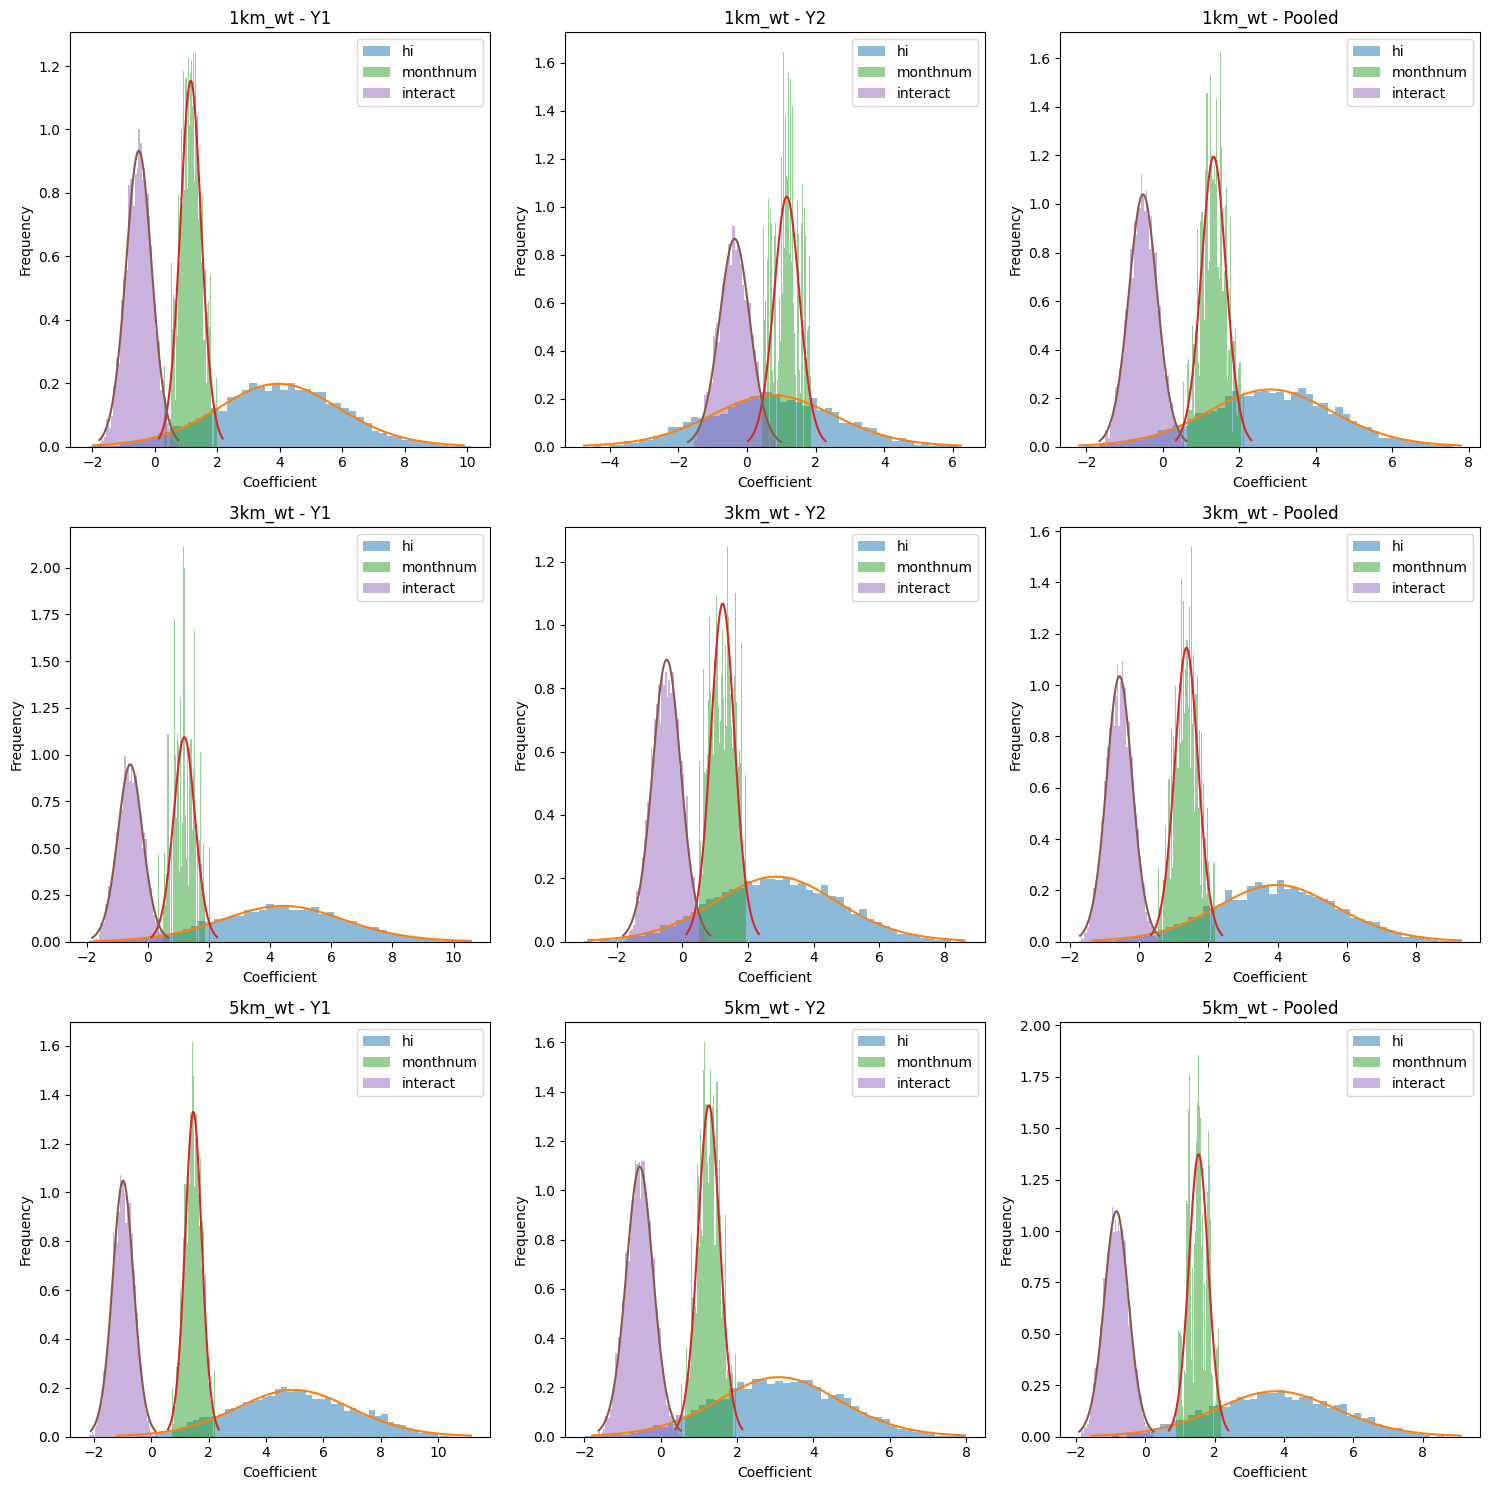

In [24]:
# plot distribution of bootstrapped coefficients
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, dist in enumerate(['1km_wt', '3km_wt', '5km_wt']):
    for j, ms in enumerate([1, 2, 3]):
        for k, var in enumerate(['hi', 'monthnum', 'interact']):
            coef = bootstrap_ests[(dist, ms)][:, k]
            mu = np.mean(coef)
            sigma = np.std(coef)
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            axs[i, j].hist(coef, bins=50, alpha=0.5, label=var, density=True)
            axs[i, j].plot(x, stats.t.pdf(x, df=16, loc=mu, scale=sigma))
            if ms == 3:
                axs[i, j].set_title(f'{dist} - Pooled')
            else:
                axs[i, j].set_title(f'{dist} - Y{ms}')
            axs[i, j].set_xlabel('Coefficient')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].legend()

plt.tight_layout()
plt.savefig('figures/boot_dist_tab6.png')

## Table 7

In [25]:
# copy the raw data and create columns for treatment and interaction variable
ms1ms2_pooled_tab7 = ms1ms2_pooled.copy(deep=True)
# filter relevant columns
ms1ms2_pooled_tab7 = ms1ms2_pooled_tab7[['oafid', # id
                                         'treat12', 'treat13', 'treatMS1MS2', # treatment variables
                                         'inventory_trim', 'netrevenue_trim', 'logtotcons_trim', # outcome variables
                                         'Y1round2', 'Y1round3', 'Y2round1', 'Y2round2', 'Y2round3','hi','subloc','interviewdate']] # independent variables

ms1ms2_pooled_tab7.sort_index(inplace=True)
ms1ms2_pooled_tab7['z'] = pd.NA
ms1ms2_pooled_tab7['z_hi'] = pd.NA

### Running the first set of regressions

In [26]:

# list of treaments
treatments = ['treat12', 'treat13', 'treatMS1MS2']

# list of dependent variables
dependent_vars = ['inventory_trim', 'netrevenue_trim', 'logtotcons_trim']

# empty dataframes to store mean and std for output
mean_std_df = pd.DataFrame(index=pd.MultiIndex.from_product([dependent_vars,treatments], names=['dv','treat']), columns=['mean','std'])

# list of changeing independent variables depending on the treatment
independent_vars = {
    'treat12': 'Y1round2 + Y1round3',
    'treat13': 'Y2round2 + Y2round3',
    'treatMS1MS2': 'Y1round2 + Y1round3 + Y2round1 + Y2round2 + Y2round3'
    }

# empty dictionary to store results
results = {}
pvals = {var: [] for var in ['z', 'hi', 'z_hi','z+z_hi']}

# Simulating the loop to replace variables and run regressions
for dv in dependent_vars:
    for treat in treatments:
        # Stata automatically omits the missing values in the regression – here we have to do it manually so we copy the data and drop variables
        df = ms1ms2_pooled_tab7.copy(deep=True)
        df = df.dropna(subset=[dv, treat, 'hi', 'subloc','interviewdate'])

        # store mean and std for output
        mean_std_df.loc[(dv, treat),'mean'] = df.loc[df[treat] == 0, dv].mean()
        mean_std_df.loc[(dv, treat),'std'] = df.loc[df[treat] == 0, dv].std()
        
        # setting treament variable
        df['z'] = df[treat] # setting z to the treatment variable

        # setting interaction variable
        df['z_hi'] = df[treat]*df['hi'] # setting z_hi to the interaction of the treatment hi saturation

        # setting the formula to run the regression
        formula = f'{dv} ~ z + hi + z_hi + interviewdate + {independent_vars[treat]}'

        # Run the regression
        model_key = f'model_{dependent_vars.index(dv)*len(treatments) + treatments.index(treat)}'
        results[model_key] = smf.ols(formula, data=df).fit(cov_type='cluster', cov_kwds={'groups': df['subloc']})

        # test the hypothesis that z + z_hi = 0
        hypothesis = 'z + z_hi = 0'
        t_test = results[model_key].t_test(hypothesis, use_t=True)

        # store p-value round to 3 decimals
        pvals['z+z_hi'].append(t_test.pvalue)
        
        # calculate t-test p-values for z, hi, z_hi
        for var in ['z', 'hi', 'z_hi']:
            pval = 2 * (1 - stats.t.cdf(abs(results[model_key].params[var] / results[model_key].bse[var]),df=df[f'subloc'].nunique()-1))
            pvals[var].append(pval)

In [27]:
pvals = pd.DataFrame(pvals).T
pvals = pvals.map(lambda x: '<0.001' if x < 0.0005 else np.round(x,3))

mean_std_df['mean'] = mean_std_df['mean'].astype(float).round(3)
mean_std_df['std'] = mean_std_df['std'].astype(float).round(3)
mean_std_df = mean_std_df.T

### Running boostrap regressions

In [28]:
n_bootstraps = 5000  # reported data is based on 5000 iterations
bootstrap_ests = {}
bootstrap_pvals = pd.DataFrame(index=pd.MultiIndex.from_product([dependent_vars, treatments], names=['treatment', 'dep_var']), columns=['z','hi','z_hi'])

for dv in dependent_vars:
    for treat in treatments:
        df = ms1ms2_pooled_tab7.copy(deep=True)
        df = df.dropna(subset=[dv, treat, 'hi', 'interviewdate','subloc'])
        df['z'] = df[treat]
        df['z_hi'] = df[treat] * df['hi']
        df[dv] = df[dv].astype(float)

        formula = f'{dv} ~ z + hi + z_hi + interviewdate + {independent_vars[treat]}'
        model_key = f'model_{dependent_vars.index(dv)*len(treatments) + treatments.index(treat)}'
        model = results[model_key]

        # Wild bootstrap        
        boot_ests, boot_pval = cgmwildboot(df, model,n_bootstraps, 'subloc','subloc',seed=5005)
        bootstrap_ests[(dv,treat)] = boot_ests

        for i, var in enumerate(['z', 'hi', 'z_hi']):
            bootstrap_pvals.loc[(dv,treat),var] = boot_pval[i]

In [29]:
bootstrap_pvals = bootstrap_pvals.T
bootstrap_pvals = bootstrap_pvals.map(lambda x: '<0.001' if x < 0.0005 else np.round(x,3))

### Output to LaTeX

In [30]:
# use stargazer to create a table
result_list = list(results.values())
stargazer = Stargazer(result_list)

# configure Stargazer object for output
stargazer.custom_columns(['Inventory', 'Net Revenues', 'Consumption'], [3, 3, 3])
stargazer.rename_covariates({'z': 'Treat', 'hi': 'High', 'z_hi': 'Treat x High'})
stargazer.show_degrees_of_freedom(False)
stargazer.significant_digits(3)
stargazer.covariate_order(['z', 'hi', 'z_hi'])
stargazer.show_adj_r2 = False
stargazer.show_f_statistic = False
stargazer.show_residual_std_err = False
stargazer.show_notes = False

# adding custom rows with mean, sd, and p-values
stargazer.add_line('Mean DV', mean_std_df.loc['mean'].tolist(),location='fb')
stargazer.add_line('SD DV', mean_std_df.loc['std'].tolist(),location='fb')
stargazer.add_line('P-value T + TH = 0', pvals.loc['z+z_hi'].tolist(),location='fb')
stargazer.add_line('P-value Treat', pvals.loc['z'].tolist(),location='fb')
stargazer.add_line('P-value Treat Bootstrap', bootstrap_pvals.loc['z'].tolist(),location='fb')
stargazer.add_line('P-value High', pvals.loc['hi'].tolist(),location='fb')
stargazer.add_line('P-value High Bootstrap', bootstrap_pvals.loc['hi'].tolist(),location='fb')
stargazer.add_line('P-value Treat x High', pvals.loc['z_hi'].tolist())
stargazer.add_line('P-value Treat x High Bootstrap', bootstrap_pvals.loc['z_hi'].tolist(),location='fb')

latex_table7 = stargazer.render_latex()

# edit the latex table to add row for telling if Y1 Y2 or Pooled after \\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\
latex_table7 = latex_table7.replace("\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \\",
                                "\\[-1.8ex] & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8) & (9) \n \\\ & Y1 & Y2 & Pooled & Y1 & Y2 & Pooled & Y1 & Y2 & Pooled \\")
latex_table7 = latex_table7.replace("\\begin{table}[!htbp] \\centering", "")
latex_table7 = latex_table7.replace("\\end{table}", "")

with open('tables/table7.tex','w') as file:
    file.write(latex_table7)

### Creating Appendix Figure

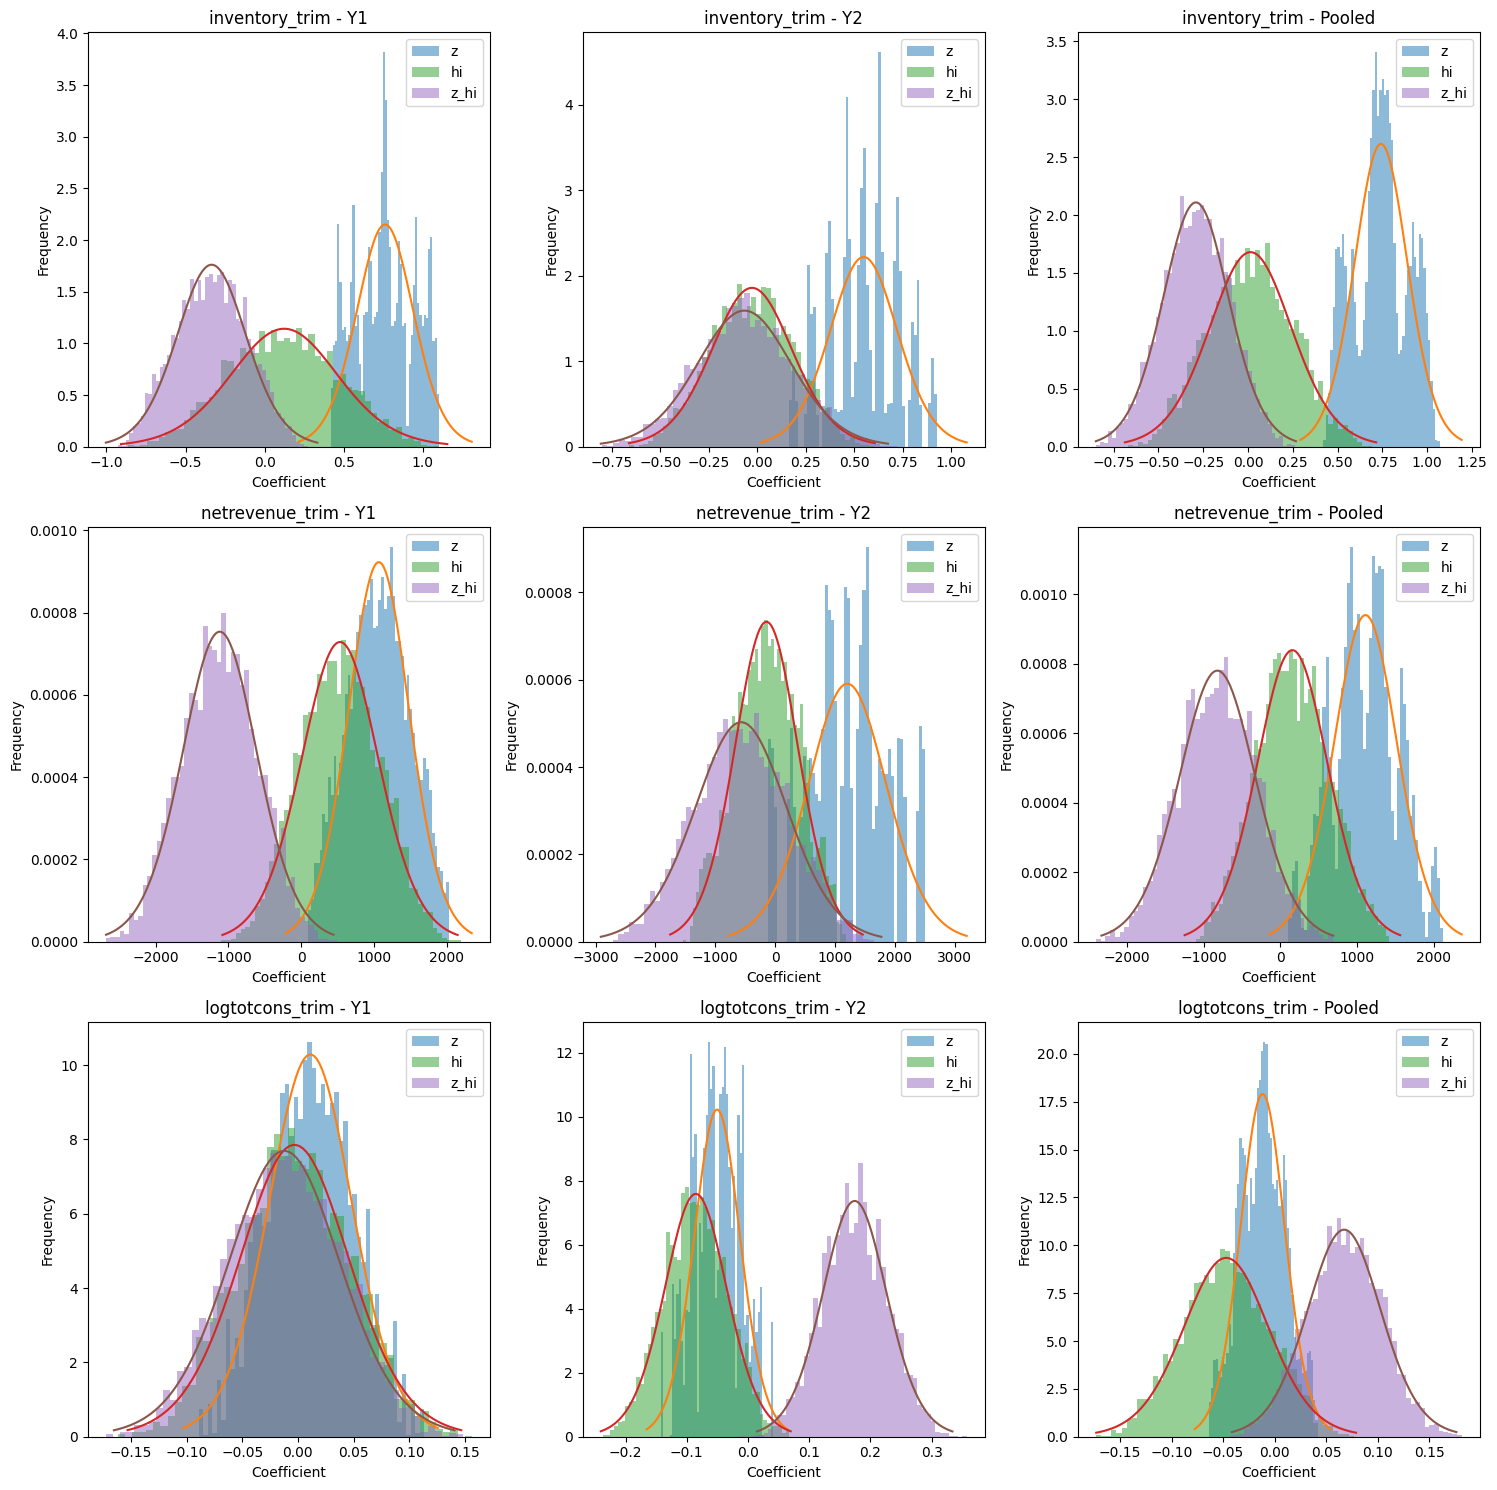

In [31]:
# plot distribution of bootstrapped coefficients
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i, dv in enumerate(['inventory_trim', 'netrevenue_trim', 'logtotcons_trim']):
    for j, treat in enumerate(['treat12', 'treat13', 'treatMS1MS2']):
        for k, var in enumerate(['z', 'hi', 'z_hi']):
            coef = bootstrap_ests[(dv, treat)][:, k]
            mu = np.mean(coef)
            sigma = np.std(coef)
            x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
            axs[i, j].hist(coef, bins=50, alpha=0.5, label=var, density=True)
            axs[i, j].plot(x, stats.t.pdf(x, df=ms1ms2_pooled_tab7['subloc'].nunique()-1, loc=mu, scale=sigma))
            if j == 2:
                axs[i, j].set_title(f'{dv} - Pooled')
            else:
                axs[i, j].set_title(f'{dv} - Y{j+1}')
            axs[i, j].set_xlabel('Coefficient')
            axs[i, j].set_ylabel('Frequency')
            axs[i, j].legend()

plt.tight_layout()
plt.savefig('figures/boot_dist_tab7.png')

## Table 8

In [32]:
tab8_dt = ms1ms2_pooled.loc[:, ['treatMS1MS2', 'hi', 'treatMS1MS2hi', 'interviewdate', 'netrevenue_trim', 'strata_group', 'groupnum', 'subloc', 'Y1round1', 'Y1round2', 'Y1round3', 'Y2round1', 'Y2round2', 'Y2round3']].dropna()
tab8_dt['net_revenue_3'] = tab8_dt['netrevenue_trim'] * 3
model = smf.ols('net_revenue_3 ~ treatMS1MS2 + hi + treatMS1MS2hi + interviewdate + Y1round1 + Y1round2 + Y1round3 + Y2round1 + Y2round2 + Y2round3', data=tab8_dt)
results_t8 = model.fit(cov_type='cluster', cov_kwds={'groups': tab8_dt['subloc']})
model_params_t8 = results_t8.params

In [33]:
# Annualized coefficients
treat_coef = model_params_t8['treatMS1MS2']
treat_hi_coef = (model_params_t8['treatMS1MS2'] + model_params_t8['treatMS1MS2hi'])
hi_coef = model_params_t8['hi']

# Direct beneficiary population
direct_beneficiary_pop_low = 247.0
direct_beneficiary_pop_high = 495.0

# Total direct gains
total_direct_gains_low = treat_coef * direct_beneficiary_pop_low
total_direct_gains_high = treat_hi_coef * direct_beneficiary_pop_high

# Total indirect gains (only applicable to high saturation areas)
total_indirect_gains_high = hi_coef * 3553.0

# Total gains
total_gains_low = total_direct_gains_low
total_gains_high = total_direct_gains_high + total_indirect_gains_high

# Fraction of gains direct
fraction_gains_direct_low = 1  # All gains are direct in low saturation
fraction_gains_direct_high = total_direct_gains_high / total_gains_high

# Fraction of gains indirect (only applicable to high saturation areas)
fraction_gains_indirect_high = total_indirect_gains_high / total_gains_high

table_8 = {
    "1. Direct gains/HH (Ksh)": [treat_coef, treat_hi_coef],
    "2. Indirect gains/HH (Ksh)": [0, hi_coef],
    "3. Ratio of indirect to direct gains": [0, hi_coef / treat_hi_coef],
    "4. Direct beneficiary population (HH)": [direct_beneficiary_pop_low, direct_beneficiary_pop_high],
    "5. Total local population (HH)": [3553.0, 3553.0],
    "6. Total direct gains (Ksh)": [total_direct_gains_low, total_direct_gains_high],
    "7. Total indirect gains (Ksh)": [0, total_indirect_gains_high],
    "8. Total gains (direct + indirect; Ksh)": [total_gains_low, total_gains_high],
    "9. Fraction of gains direct": [fraction_gains_direct_low, fraction_gains_direct_high],
    "10. Fraction of gains indirect": [0, fraction_gains_indirect_high],
}

# Convert the calculations to DataFrame and transpose it
table_8_df = pd.DataFrame(table_8, index=["Low Saturation", "High Saturation"]).T

# Now you can print table_8_df to see the recreated table
table_8_df

latex_table8 = table_8_df.to_latex(index=True, float_format="%.3f")
latex_table8 = latex_table8.replace('\\toprule', '\\\[-1.8ex]\hline \n \hline \\\[-1.8ex]')
latex_table8 = latex_table8.replace('\\bottomrule', '\\\[-1.8ex]\hline \n \hline \\\[-1.8ex]')

with open('tables/table8.tex','w') as file:
    file.write(latex_table8)